In [1]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [2]:
# Most basic stuff for EDA.

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# !pip install transformers
# !pip install datasets
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer 

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_tweets = pd.read_csv('../data/train.csv')
test_tweets = pd.read_csv('../data/test.csv')

In [4]:
train_tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<AxesSubplot:xlabel='count', ylabel='target'>

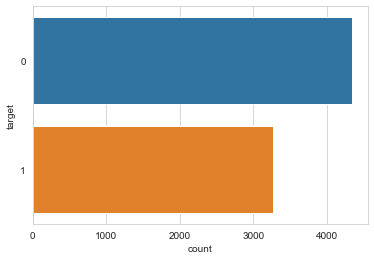

In [5]:
sns.set_style('whitegrid')
sns.countplot(y=train_tweets['target'])

In [6]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.
import re
import string

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions on Train Dataset

train_tweets['text_clean'] = train_tweets['text'].apply(lambda x: remove_URL(x))
train_tweets['text_clean'] = train_tweets['text_clean'].apply(lambda x: remove_emoji(x))
train_tweets['text_clean'] = train_tweets['text_clean'].apply(lambda x: remove_html(x))
train_tweets['text_clean'] = train_tweets['text_clean'].apply(lambda x: remove_punct(x))

# Applying helper functions on Test Dataset

test_tweets['text_clean'] = test_tweets['text'].apply(lambda x: remove_URL(x))
test_tweets['text_clean'] = test_tweets['text_clean'].apply(lambda x: remove_emoji(x))
test_tweets['text_clean'] = test_tweets['text_clean'].apply(lambda x: remove_html(x))
test_tweets['text_clean'] = test_tweets['text_clean'].apply(lambda x: remove_punct(x))

In [7]:
train_tweets.fillna("",inplace=True)
test_tweets.fillna("",inplace=True)

In [8]:
model_nm = 'microsoft/deberta-v3-small'
tokz = AutoTokenizer.from_pretrained(model_nm)
sep = tokz.sep_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
train_tweets['train'] = train_tweets['text_clean'] + sep + train_tweets['location'] + sep + train_tweets['keyword']
test_tweets['train'] = test_tweets['text_clean'] + sep + test_tweets['location'] + sep + test_tweets['keyword']

In [10]:
train_tweets.head()

,id,keyword,location,text,target,text_clean,train
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,Our Deeds are the Reason of this earthquake Ma...
1,4,,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,Forest fire near La Ronge Sask Canada[SEP][SEP]
2,5,,,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,All residents asked to shelter in place are be...
3,6,,,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,13000 people receive wildfires evacuation orde...
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,Just got sent this photo from Ruby Alaska as s...


# Process the dataset

In [11]:
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

from datasets import load_dataset, Dataset, DatasetDict


In [12]:
ds = Dataset.from_pandas(train_tweets)

In [13]:
ds[0]

{'id': 1,
 'keyword': '',
 'location': '',
 'text': 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'target': 1,
 'text_clean': 'Our Deeds are the Reason of this earthquake May ALLAH Forgive us all',
 'train': 'Our Deeds are the Reason of this earthquake May ALLAH Forgive us all[SEP][SEP]'}

Building the vocab

In [14]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from collections import Counter
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pad_sequence
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']


In [15]:
tokenizer = get_tokenizer('spacy', language='de_core_news_sm')

def yield_tokens(ds):
    for row in ds:
        yield tokenizer(row['train'])
    
vocab_transform = build_vocab_from_iterator(yield_tokens(ds), specials=special_symbols,min_freq=1,special_first=True)
print('length of vocabulary ', len(vocab_transform))
vocab_transform.set_default_index(UNK_IDX)

length of vocabulary  24859


In [16]:
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
            
        return txt_input
    
    return func

def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

In [1]:
text_transform = sequential_transforms(
    tokenizer,
    vocab_transform,
    tensor_transform
)

NameError: name 'sequential_transforms' is not defined

In [18]:
def tok_func(x):
    return {'input_ids': text_transform(x['train'])}

In [19]:
tok_ds = (ds.map(tok_func, batched=False, remove_columns=['id', 'keyword', 'location', 'text', 'text_clean'])
.rename_column('target','label'))

  0%|          | 0/7613 [00:00<?, ?ex/s]

In [20]:
tok_ds[0]

{'label': 1,
 'train': 'Our Deeds are the Reason of this earthquake May ALLAH Forgive us all[SEP][SEP]',
 'input_ids': [2,
  742,
  6359,
  34,
  8,
  3220,
  14,
  35,
  261,
  1209,
  9700,
  12376,
  232,
  59,
  5,
  9,
  4,
  3]}

In [21]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self,input_ids = None, attention_mask = None, labels = None):
        import pdb
        pdb.set_trace()
        embedded = self.embedding(input_ids)
        return self.fc(embedded)

In [22]:
vocab_size = len(vocab_transform)
emsize = 64
num_class = 2
model = TextClassificationModel(vocab_size, emsize, num_class)

accuracy = load_metric("accuracy")
f1 = load_metric('f1')
lr,bs = 8e-5,32
wd,epochs = 0.01,4
model_nm = 'microsoft/deberta-v3-small'

In [23]:
dds = tok_ds.train_test_split(test_size=0.2)
    
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
num_train_epochs=epochs, weight_decay=wd, report_to='none')

In [24]:
from datasets import load_metric
accuracy = load_metric("accuracy")
f1 = load_metric('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy.compute(predictions = predictions, references=labels)['accuracy'],
        'f1': f1.compute(predictions = predictions, references=labels)['f1']
    }

In [25]:
dds['train']

Dataset({
    features: ['label', 'train', 'input_ids'],
    num_rows: 6090
})

In [26]:
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
               tokenizer=tokz, compute_metrics=compute_metrics)#
    

Using amp fp16 backend


In [27]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dds['train'],batch_size=4, shuffle=True)

In [28]:
dds['train']

Dataset({
    features: ['label', 'train', 'input_ids'],
    num_rows: 6090
})

In [29]:
dds['train']

Dataset({
    features: ['label', 'train', 'input_ids'],
    num_rows: 6090
})

In [30]:

trainer.train(ignore_keys_for_eval=['hidden_states','attentions'])

--Return--
None
> /tmp/ipykernel_156065/2882761175.py(2)<module>()
      1 import pdb
----> 2 pdb.set_trace()
      3 trainer.train(ignore_keys_for_eval=['hidden_states','attentions'])

Breakpoint 1 at /home/puneet/Envs/venv/lib/python3.9/site-packages/transformers/trainer.py:1871
Breakpoint 2 at /home/puneet/Envs/venv/lib/python3.9/site-packages/transformers/trainer.py:1871


The following columns in the training set  don't have a corresponding argument in `TextClassificationModel.forward` and have been ignored: train.
***** Running training *****
  Num examples = 6090
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 384


> /home/puneet/Envs/venv/lib/python3.9/site-packages/transformers/trainer.py(1877)compute_loss()
   1875         Subclass and override for custom behavior.
   1876         """
-> 1877         if self.label_smoother is not None and "labels" in inputs:
   1878             labels = inputs.pop("labels")
   1879         else:

> /home/puneet/Envs/venv/lib/python3.9/site-packages/transformers/trainer.py(1880)compute_loss()
   1878             labels = inputs.pop("labels")
   1879         else:
-> 1880             labels = None
   1881         outputs = model(**inputs)
   1882         # Save past state if it exists

> /home/puneet/Envs/venv/lib/python3.9/site-packages/transformers/trainer.py(1881)compute_loss()
   1879         else:
   1880             labels = None
-> 1881         outputs = model(**inputs)
   1882         # Save past state if it exists
   1883         # TODO: this needs to be fixed and made cleaner later.

DataParallel(
  (module): TextClassificationModel(
    (embedding): E

: 

: 